Exploring Decision Trees
========================

Use a decision tree classifier to create a simplified model exploring the "Sex", "Age" and "Fare Per Person" features.

In [1]:
# set up code and dataframe with training data
import pandas as pd
import numpy as np
import statistics as st

import sklearn.metrics as ms
import sklearn.tree as tr
import sklearn.model_selection as mds
import matplotlib.pyplot as plt

datestamp = "20250129.150949"
df_ = pd.read_csv(f"../data/kaggle/train.clean.{datestamp}.csv")
print(df_.shape)

(891, 21)


In [2]:
x_colnames = [ "SexOrd", "AgeImputed", "Pclass", "FarePerPerson" ]
y_colname = [ "Survived" ]

X = df_[ x_colnames ]
y = df_[ y_colname ].values

print(X.info())

# Assuming you have your features in X and your target variable in y
X_train, X_test, y_train, y_test = mds.train_test_split(X, y, test_size=0.2, random_state=5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SexOrd         891 non-null    float64
 1   AgeImputed     891 non-null    float64
 2   Pclass         891 non-null    int64  
 3   FarePerPerson  891 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 28.0 KB
None


In [3]:
n_folds = 6
s_scoring = "accuracy"

param_dist = {
    'max_leaf_nodes': [ 5, 6, 7 ],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [10, 25, 50, 75 ],
    'min_samples_leaf': [10, 20, 30, 40, 50, 60]
} 

# Create a decision tree classifier
clf = tr.DecisionTreeClassifier(random_state=5)

grid_search = mds.GridSearchCV( estimator=clf,
                                param_grid=param_dist,
                                cv=n_folds,
                                scoring=s_scoring,
                                n_jobs=-1 )


# Train the classifier
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
model       = grid_search.best_estimator_

print(best_params)
print()

importances = model.feature_importances_
feature_imp_df = pd.DataFrame(
    {'Feature': x_colnames, 'Gini Importance': importances} ).sort_values(
         'Gini Importance', ascending=False)
print(feature_imp_df)


{'max_depth': 3, 'max_leaf_nodes': 6, 'min_samples_leaf': 40, 'min_samples_split': 10}

         Feature  Gini Importance
0         SexOrd         0.676634
2         Pclass         0.177178
3  FarePerPerson         0.102201
1     AgeImputed         0.043987


In [4]:
print(tr.export_text(model, show_weights=True, feature_names=x_colnames, class_names=['Dead', 'Alive']))

|--- SexOrd <= 0.50
|   |--- Pclass <= 2.50
|   |   |--- weights: [6.00, 126.00] class: Alive
|   |--- Pclass >  2.50
|   |   |--- FarePerPerson <= 7.23
|   |   |   |--- weights: [37.00, 21.00] class: Dead
|   |   |--- FarePerPerson >  7.23
|   |   |   |--- weights: [24.00, 41.00] class: Alive
|--- SexOrd >  0.50
|   |--- FarePerPerson <= 26.14
|   |   |--- AgeImputed <= 17.50
|   |   |   |--- weights: [24.00, 16.00] class: Dead
|   |   |--- AgeImputed >  17.50
|   |   |   |--- weights: [289.00, 32.00] class: Dead
|   |--- FarePerPerson >  26.14
|   |   |--- weights: [58.00, 38.00] class: Dead



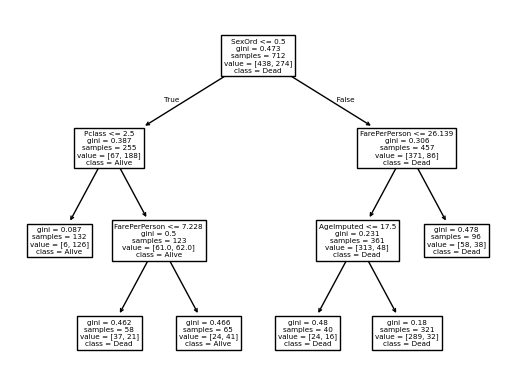

In [5]:
tr.plot_tree(model, feature_names=x_colnames, class_names=['Dead', 'Alive'])
plt.show()

In [6]:
l_raw_scores = mds.cross_val_score(model, X_test, y_test, scoring=s_scoring, cv=n_folds)
l_scores = [ round(i, 2) for i in l_raw_scores ]

mean_score = round(st.mean(l_scores), 3)
std_score = round(st.stdev(l_scores), 3)

print(f"{n_folds}-fold {s_scoring} mean: {mean_score}, stdev: {std_score}")
print(f"  each: {l_scores}")

6-fold accuracy mean: 0.793, stdev: 0.084
  each: [np.float64(0.83), np.float64(0.63), np.float64(0.8), np.float64(0.8), np.float64(0.87), np.float64(0.83)]


In [7]:
threshold = 0.4
y_test_preds_proba = model.predict_proba(X_test)
y_test_preds = (y_test_preds_proba[:,1] > threshold).astype(int)

tn, fp, fn, tp = ms.confusion_matrix(y_test, y_test_preds).ravel()
print(f"Confusion Matrix, at Threshold {threshold:.3f}")
print(f"  tn {tn:<3}  fp {fp:<3}")
print(f"  fn {fn:<3}  tp {tp:<3}")
print()

Confusion Matrix, at Threshold 0.400
  tn 103  fp 8  
  fn 27   tp 41 

